In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import math
import cmath
import pandas as pd

In [2]:
x_min = 0
x_max = 1.8
c = 1.5
a = 0.6
b = 1.2
T = 3
I = 100
C = 0.5

In [3]:
xs = symbols('x')
u0s = exp(-4 * (2*xs - (a+b))**2 / ((b-a)**2 - (2*xs - (a+b))**2) )
dudt2s = c**2 * u0s.diff(xs, 2)

u_init0 = lambda x: u0s.subs(xs, x) if a < x < b else 0
u_init1 = lambda x, tau: u_init0(x) + (tau**2 / 2) * dudt2s.subs(xs, x) if a < x < b else 0

In [4]:
def generate_grid(I, C=0.5):
    h = (x_max - x_min)/I
    tau = C*(h/c)
    N = math.ceil(T/tau)

    xx = [x_min + (i-0.5)*h for i in range(I+1)]
    tt = [n*tau for n in range(N+1)]
    return tt, xx


def generate_grid_w_ext(I, C=0.5):
    h = (x_max - x_min)/I
    I_ext = 2 * I
    xx_ext = [x_min + (i-0.5)*h for i in range(I_ext + 1)]
    return *generate_grid(I, C), xx_ext

In [5]:
class Params:
    def __init__(self, xx, tt, lmd, L=16):
        self.xx = xx
        self.tt = tt
        self.lmd = lmd
        self.L = L
        self.h = np.diff(xx)[0]
        self.tau = np.diff(tt)[0]
        self.N = len(tt)
        self.I = len(xx)
        self.K = get_K(lmd, tt, self.tau, L)


def get_K(lmd, tt, tau, L):
    coef = np.loadtxt(f'kern/coef{L}.dat')
    aa = list(map(lambda a: c * (lmd**2) * a, [(x[0] + 1j*x[1]) for x in coef]))
    bb = list(map(lambda b: c * lmd * b, [x[2] + 1j*x[3] for x in coef]))

    A_cache = {}
    def A(u, n, b):
        key = str([u.shape[1], n, b])
        if key in A_cache.keys():
            return A_cache[key]
        if n == 0:
            result = 0
            A_cache[key] = result
            return result
        points = [
            tt[n] - 0.5*tau,
            tt[n],
            tt[n] + 0.5*tau
        ]
        values = [
            (u[n, -2] + u[n-1, -1]) / 2,
            4 * (u[n, -2] + u[n, -1]) / 2,
            (u[n+1, -2] + u[n, -1]) / 2
        ]
        Int = tau * np.sum([cmath.exp(b*(points[2] - points[i])) * values[i] for i in range(3)]) / 6
        result = cmath.exp(b*tau) * A(u, n-1, b) + Int
        A_cache[key] = result
        return result
    
    K = lambda u, n: complex(np.sum([aa[i]*A(u, n, bb[i]) for i in range(len(aa))])).real
    return K

In [6]:
def step(p, u, n, i):
    a1 = ((p.tau*c/p.h)**2) * (u[n, i+1] - 2 * u[n, i] + u[n, i-1])
    a2 = -((p.lmd*c*p.tau)**2)*u[n, i]
    return 2*u[n, i] - u[n-1, i] + a1 + a2

def right_boundary_condition(p, u, n, i):
        a1 = -p.h*(u[n+1, i-1] - u[n, i-1] - u[n, i])
        a2 = -c*p.tau*(u[n, i] - u[n, i-1] - u[n+1, i-1])
        k = p.K(u, n)
        a3 = -2*c*p.tau*p.h*k
        return (a1 + a2 + a3) / (p.h + c*p.tau)

def solve(p):
    u = np.zeros((len(p.tt), len(p.xx)))

    u[0, :] = [u_init0(x) for x in p.xx]
    u[1, :] = [u_init1(x, p.tau) for x in p.xx]
    for n, t in enumerate(p.tt[:-1]):
        if n == 0:
            continue
        for i in range(1, p.I):
            if i == 1:
                u[n+1, 0] = 0
            elif i == p.I - 1:
                u[n+1, i] = right_boundary_condition(p, u, n, i)
            else:
                u[n+1, i] = step(p, u, n, i)
    return u

In [7]:
def plot_solution(p, v, label='u', xlim=None, ylim=None):
    plt.plot(p.xx, v)
    plt.grid()
    plt.xlabel('t')
    plt.ylabel(label)
    plt.xlim(xlim)
    plt.ylim(ylim)


def get_time_idx(p, t):
    for i, x in enumerate(p.tt):
        if abs(x-t) <= p.tau/2:
            return i


def plot_comparison(p1, p2, uu, ww, t):
    fig, ax = plt.subplots()
    fig.suptitle(f'$\lambda = {p1.lmd}, I = {p1.I}, t = {t}$', fontsize=12)
    fig.set_size_inches(16, 10)
    fig.tight_layout()

    time_idx = get_time_idx(p1, t)
    u = uu[time_idx, :]
    w = ww[time_idx, :]
    diff = u - w[:len(p1.xx)]
    xlim = (p2.xx[0], p2.xx[-1])
    ylim = (min(np.min(u), np.min(w))*1.1,  max(np.max(u), np.max(w))*1.1)
    plt.subplot(3, 1, 1)
    plot_solution(p1, u, 'u', xlim, ylim)

    plt.subplot(3, 1, 2)
    plot_solution(p2, w, 'w', xlim, ylim)

    plt.subplot(3, 1, 3)
    plot_solution(p1, diff, 'u - w', xlim)


In [8]:
def solve_twice(lmd, I, L=16, C=0.5):
    tt, xx, xx_ext = generate_grid_w_ext(I, C)
    p1 = Params(xx, tt, lmd, L)
    p2 = Params(xx_ext, tt, lmd, L)
    u = solve(p1)
    w = solve(p2)
    return p1, p2, u, w

## Графики решений в моменты времени t = 0, 1, 2, 3

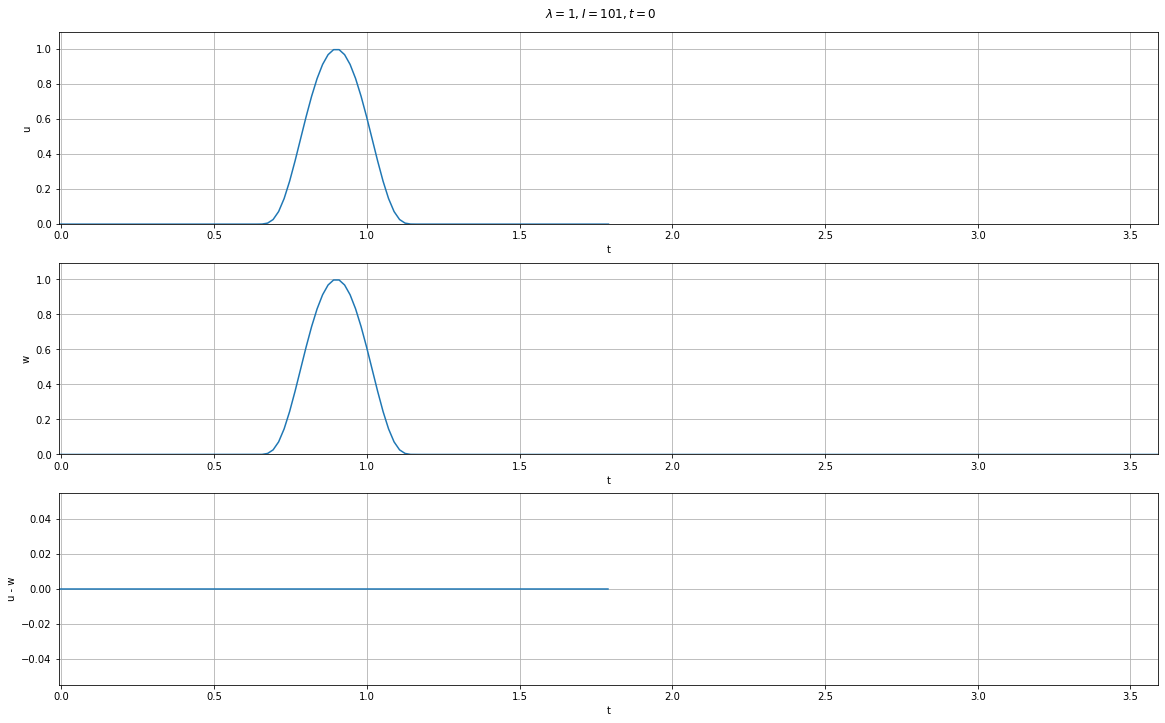

In [9]:
sol = solve_twice(1, 100)
plot_comparison(*sol, 0)

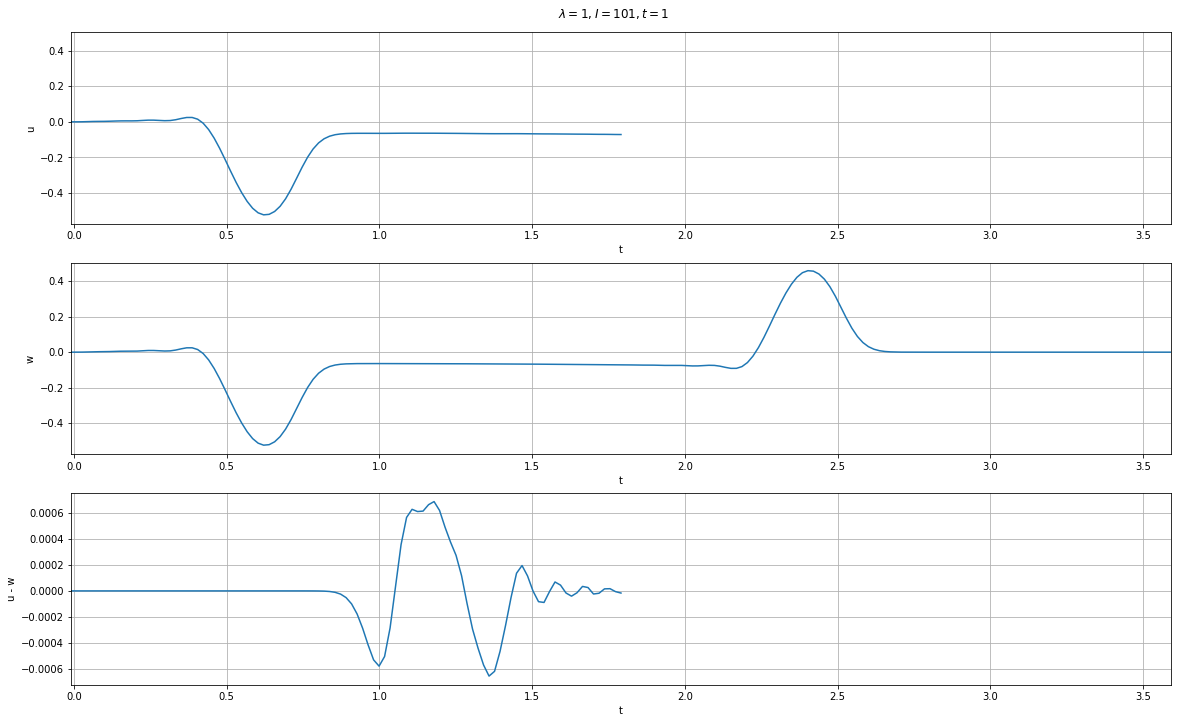

In [10]:
plot_comparison(*sol, 1)

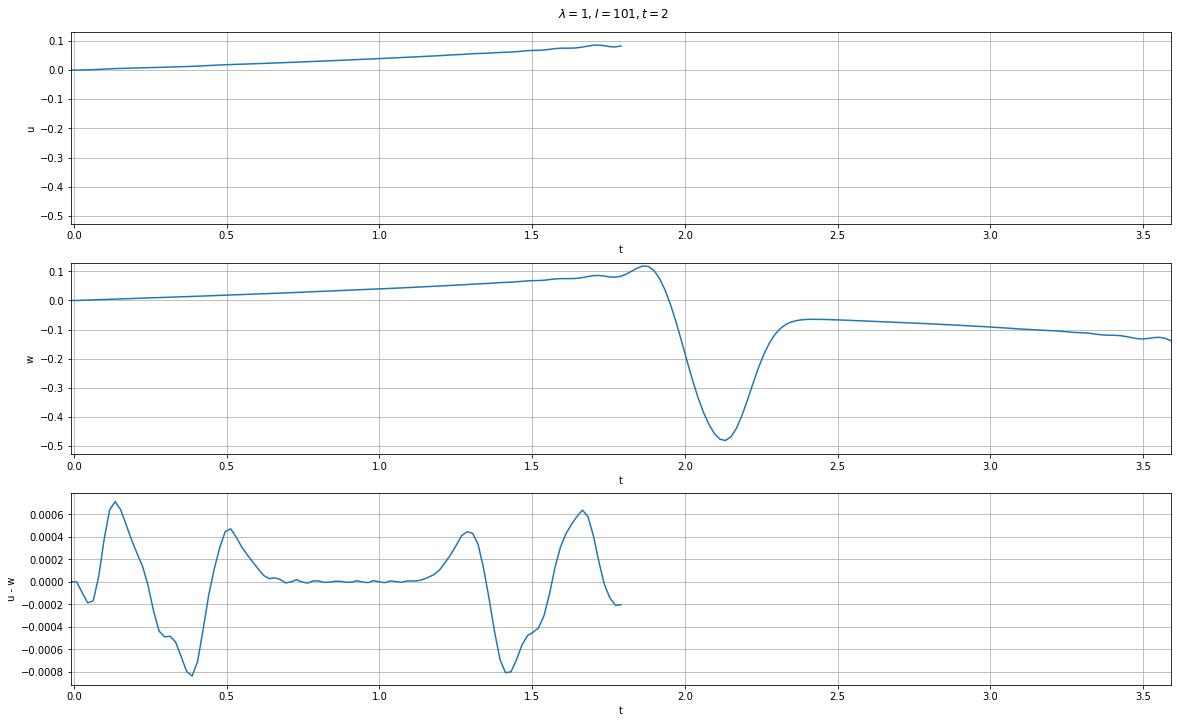

In [11]:
plot_comparison(*sol, 2)

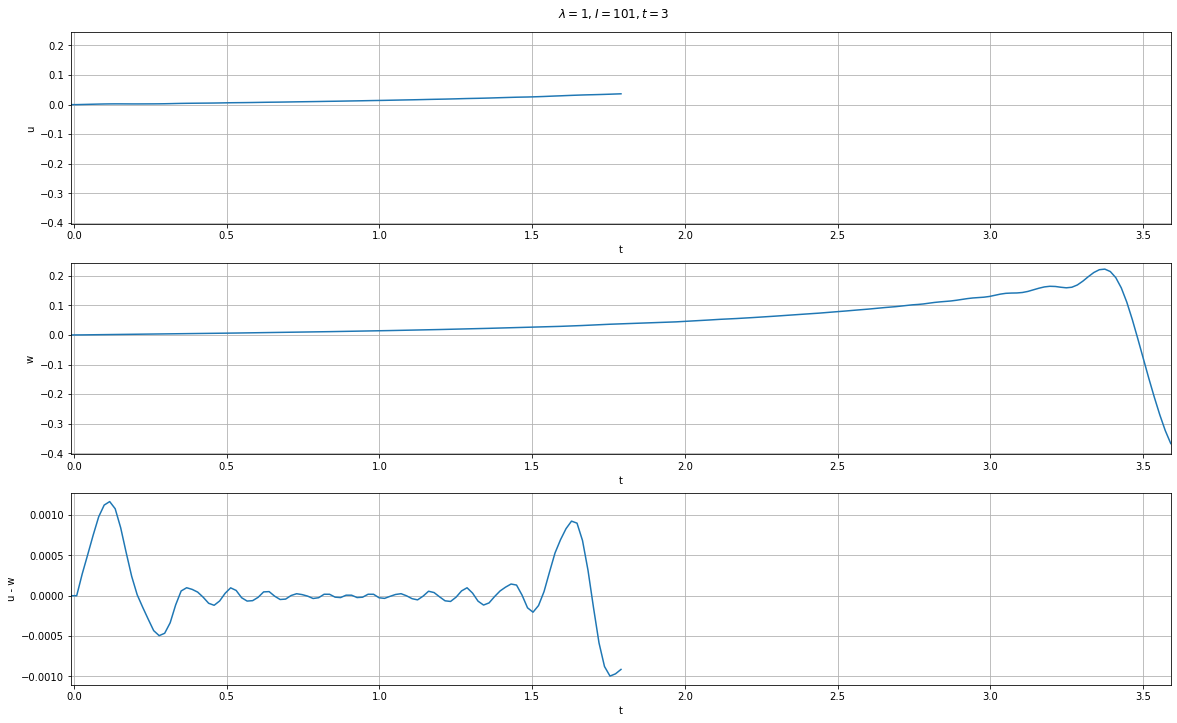

In [12]:
plot_comparison(*sol, 3)

## График ошибки

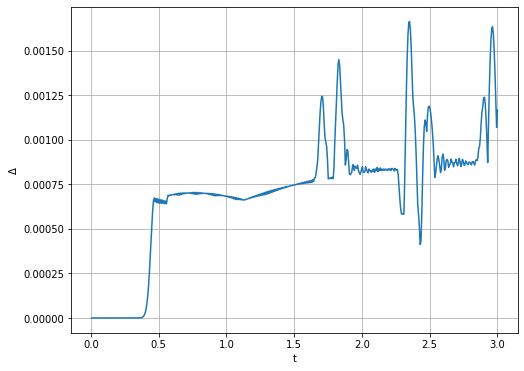

In [13]:
def get_error(sol, t=-1):
    p1, p2, u, w = sol
    diff = u[t, :] - w[t, :len(p1.xx)]
    return np.abs(diff).max()


def get_error_norm(sol):
    return np.abs([get_error(sol, t) for t in range(sol[0].N)]).max()


def plot_errors(sols, labels=None):
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    fig.tight_layout()
    for i, sol in enumerate(sols):
        tt = sol[0].tt[1:]
        err = [get_error(sol, t)for t in range(1, sol[0].N)]
        label = labels[i] if labels else None
        plt.plot(tt, err, label=label)
    plt.grid()
    plt.xlabel('t')
    plt.ylabel('$\Delta$')
    if labels:
        plt.legend()


plot_errors([sol])

## Проверка второго порядка сеточной сходимости

In [14]:
lmd = 3
II = [30, 90, 270]
errors = [get_error_norm(solve_twice(lmd, I)) for I in II]
EOC = [math.log(errors[i]/errors[i+1], 3) for i in range(len(II) - 1)]
pd.DataFrame({'I': II, 'Delta': errors, 'EOC': ['', *EOC]})

## Влияние L = 16, 17, 33, 65 на точность

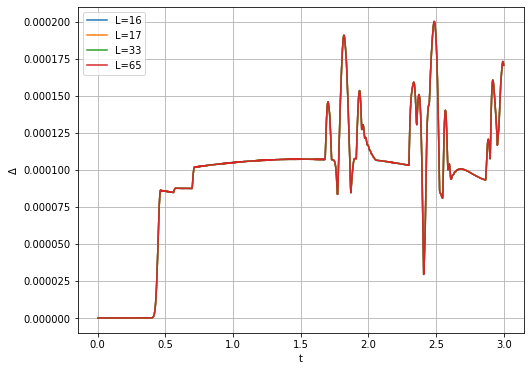

In [ ]:
LL = [16, 17, 33, 65]
sols = [solve_twice(lmd, 270, L) for L in LL]
plot_errors(sols, [f'L={L}' for L in LL])

Выбор параметра L не влияет на точность

## Влияние $\lambda$ = 0, 1, 3, 6 на точность

In [ ]:
lmds = [0, 1, 3, 6]
sols = [solve_twice(lmd, 270) for lmd in lmds]
errors = [get_error_norm(sol) for sol in sols]
pd.DataFrame({'lambda': lmds, 'Delta': errors})

,lambda,Delta
0,0,0.000190
1,1,0.000190
2,3,0.000200
3,6,0.000231


Выбор $\lambda$ незначительно влияет на точность